<a href="https://colab.research.google.com/github/Modinat-A/CE888/blob/main/lab3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

In [61]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv',delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [17]:
print(df['nr.employed'].value_counts())

5228.1    12962
5099.1     6855
5191.0     6228
5195.8     2931
5076.2     1338
5017.5      844
4991.6      638
4963.6      507
5008.7      497
5023.5      142
5176.3        8
Name: nr.employed, dtype: int64


In [62]:
features = ['job' , 'marital' , 'education', 'default' , 'housing' , 'loan' , 'contact' , 'month' ,'day_of_week', 'poutcome' ]


## Data Preprocessing

    1. Use LabelEncoder to convert the label into numbers.
    2. Perform one-hot encoding on the categorical features using df_dummies = pd.get_dummies(df)
    4. Column "duration" must be deleted
    5. Check if there are any missing values in the dataset.     
    6. If there are, drop the rows.
    7. Plot a histogram of the label (i.e., column 'y') and calculate the imbalance in the dataset (i.e., divide the number of instances of the minority class by the total length of the dataframe).

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 33429 to 19274
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32950 non-null  object 
 2   marital         32950 non-null  object 
 3   education       32950 non-null  object 
 4   default         32950 non-null  object 
 5   housing         32950 non-null  object 
 6   loan            32950 non-null  object 
 7   contact         32950 non-null  object 
 8   month           32950 non-null  object 
 9   day_of_week     32950 non-null  object 
 10  duration        32950 non-null  int64  
 11  campaign        32950 non-null  int64  
 12  pdays           32950 non-null  int64  
 13  previous        32950 non-null  int64  
 14  poutcome        32950 non-null  object 
 15  emp.var.rate    32950 non-null  float64
 16  cons.price.idx  32950 non-null  float64
 17  cons.conf.idx   32950 non-n

In [63]:
df.drop(columns=['duration'])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [64]:
# Split into training and test sets
train_set, test_set = train_test_split(df, test_size=0.2, random_state=60,stratify=df['y'])  
print(len(train_set), len(test_set))

32950 8238


In [65]:
df = train_set.copy()
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df['y'].copy()
y_df.columns = ['y']
#X_df = df[df[features]].copy()
X_df = df.loc[:, df.columns != 'y'].copy()

Number of rows before dropping NaNs: 32950
Number of rows after dropping NaNs: 32950


In [66]:
X_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
33429,28,technician,single,basic.9y,no,no,no,cellular,may,tue,223,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1
3617,53,blue-collar,married,basic.9y,no,no,no,telephone,may,fri,130,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0
37856,44,admin.,married,high.school,no,no,no,cellular,aug,fri,283,1,999,0,nonexistent,-2.9,92.201,-31.4,0.825,5076.2
5994,35,services,single,high.school,unknown,no,yes,telephone,may,tue,234,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
23428,37,technician,married,university.degree,no,no,no,cellular,aug,wed,141,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38152,37,unknown,single,university.degree,no,yes,yes,cellular,sep,wed,78,1,999,1,failure,-3.4,92.379,-29.8,0.753,5017.5
36256,31,services,married,basic.9y,no,no,no,cellular,jun,mon,84,1,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2
38241,75,retired,married,basic.9y,no,no,no,cellular,oct,mon,120,1,999,0,nonexistent,-3.4,92.431,-26.9,0.743,5017.5
6053,33,entrepreneur,married,basic.9y,unknown,no,no,telephone,may,tue,82,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [67]:
# Use LabelEncoder to convert the label into numbers.
outcomesLabelEncoder = LabelEncoder()
y_df =outcomesLabelEncoder.fit_transform( y_df.values)

In [51]:
 class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [59]:
# cat_features = features #['job' , 'marital' , 'education', 'default' , 'housing' , 'loan' , 'contact' , 'month' ,'day_of_week' , 'poutcome']
# encoder = OneHotEncoderCategoricalFeatures(cat_features)
# X_encoded = encoder.transform(X_df)
# X_encoded

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
33429,28,223,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,...,0,0,0,0,0,1,0,0,1,0
3617,53,130,2,999,0,1.1,93.994,-36.4,4.859,5191.0,...,0,0,1,0,0,0,0,0,1,0
37856,44,283,1,999,0,-2.9,92.201,-31.4,0.825,5076.2,...,0,0,1,0,0,0,0,0,1,0
5994,35,234,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,0,0,1,0
23428,37,141,5,999,0,1.4,93.444,-36.1,4.964,5228.1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38152,37,78,1,999,1,-3.4,92.379,-29.8,0.753,5017.5,...,0,1,0,0,0,0,1,1,0,0
36256,31,84,1,999,0,-2.9,92.963,-40.8,1.266,5076.2,...,0,0,0,1,0,0,0,0,1,0
38241,75,120,1,999,0,-3.4,92.431,-26.9,0.743,5017.5,...,1,0,0,1,0,0,0,0,1,0
6053,33,82,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,0,0,1,0


In [71]:
cat_features = features

encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = encoder.transform(X_df)
X_oho

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
33429,28,223,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,...,0,0,0,0,0,1,0,0,1,0
3617,53,130,2,999,0,1.1,93.994,-36.4,4.859,5191.0,...,0,0,1,0,0,0,0,0,1,0
37856,44,283,1,999,0,-2.9,92.201,-31.4,0.825,5076.2,...,0,0,1,0,0,0,0,0,1,0
5994,35,234,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,0,0,1,0
23428,37,141,5,999,0,1.4,93.444,-36.1,4.964,5228.1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38152,37,78,1,999,1,-3.4,92.379,-29.8,0.753,5017.5,...,0,1,0,0,0,0,1,1,0,0
36256,31,84,1,999,0,-2.9,92.963,-40.8,1.266,5076.2,...,0,0,0,1,0,0,0,0,1,0
38241,75,120,1,999,0,-3.4,92.431,-26.9,0.743,5017.5,...,1,0,0,1,0,0,0,0,1,0
6053,33,82,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,0,0,1,0


In [75]:
# Let's also look at standardising some of the numerical features
num_features = ['age','duration' ,'cons.conf.idx','campaign' ,'pdays' , 'previous','euribor3m','pdays','emp.var.rate','cons.price.idx','nr.employed']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X_processed = colTransformer.fit_transform(X_df)
X_processed.shape

(32950, 64)

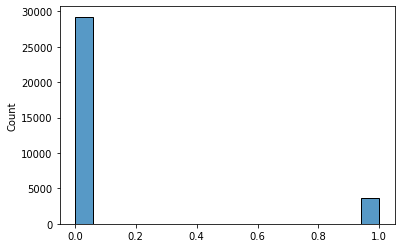

In [53]:
y = y_df
_ = sns.histplot(y, kde=False)


In [76]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_processed, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X_processed)))

Dummy ACC: 0.80


In [ ]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=3)
scores = cross_val_score(clf, X_processed, y, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.90 +/- 0.00


In [78]:
scores = cross_val_score(dummy_clf, X_processed, y, cv=10, scoring=make_scorer(acc),)  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.80 +/- 0.01


In [84]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=60)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.91 +/- 0.00


In [87]:
print (sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [ ]:
# Train a random forest classifier with 200 estimators and a maximum depth of 12, 
# setting the random_state parameter to 60.

[ 1 10  6  7  4  8  2  9 63  0  5 62 45 61 51 44 54 52 46  3 55 50 57 35
 16 36 12 47 19 33 53 58 25 59 56 24 29 49 38 11 41 48 23 30 43 40 20 32
 60 34 27 13 18 28 17 22 15 14 42 21 39 26 31 37]
Feature ranking:
1. duration (0.289457)
2. nr.employed (0.142315)
3. euribor3m (0.119496)
4. pdays (0.076080)
5. pdays (0.069080)
6. emp.var.rate (0.049671)
7. cons.conf.idx (0.048049)
8. cons.price.idx (0.042430)
9. success (0.039940)
10. age (0.012939)
11. previous (0.012179)
12. nonexistent (0.011136)
13. telephone (0.008798)
14. failure (0.008362)
15. mar (0.007825)
16. cellular (0.007665)
17. oct (0.007586)
18. may (0.006279)
19. apr (0.003947)
20. campaign (0.003143)
21. sep (0.002800)
22. jun (0.002506)
23. mon (0.002152)
24. no (0.001978)
25. retired (0.001726)
26. unknown (0.001681)
27. blue-collar (0.001300)
28. aug (0.001207)
29. student (0.001109)
30. university.degree (0.000998)
31. nov (0.000816)
32. thu (0.000811)
33. single (0.000788)
34. tue (0.000775)
35. fri (0.000735)
36. m

NameError: ignored

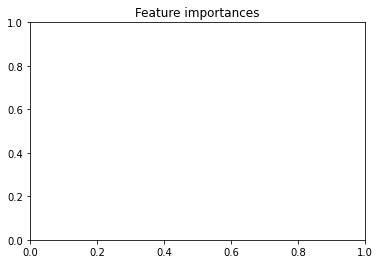

In [80]:
clf.fit(X_processed, y)

# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['age',	'campaign','pdays']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feat_names)[indices])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)
